<a href="https://colab.research.google.com/github/GitHrsh/5G-NR_Resource_Allocation/blob/main/Resource_Block_Allocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New Radio Resource Block Allocation



### Problem Statement:
Given a 5G NR base station, and 5 UEs moving dynamically within the range of the BS, allocate resource blocks optimally.
RBs are allocated according to channel quality. Our goal is to provide fairness and maximize throughput

**For Channel State Indicator, SNR is calculated from pathloss and transmission power from base station**

###Problem Setup:
Allocate a set of available Resource Blocks (RBs) to multiple User Equipments (UEs) to optimize network performance, specifically aiming to maximize data rates and maintain fairness.
Dynamic Environment: The environment is dynamic as users move, leading to changing signal strengths and path losses. The challenge is to adapt the allocation of RBs in real-time to reflect these changes.

##Approach 1: Allocation using Hopfield Neural Network

The RBs are allocated to UEs at the slot boundary
based on their channel states. Therefore, we use channel aware based
Generalized Proportional Fair (GPF) scheduling. GPF based formulation gives different
levels of the trade-off between total data rate and fairness by using
different values of the GPF parameter 𝛼. The data rate and user
fairness trade-off optimization problem has to maximize the total
data rate of all UEs while maintaining a certain level of long-term
fairness

We use an HNN, which is a type of non-training neural network, to achieve this. We set weights explicitly using CSI, and update the neurons till the Energy function achieves a global minimum. The weights are set in such a way to allow for GPF and maximized learning rates.




Final RB Allocation: {0: array([  1,   2,   6,   7,  14,  19,  27,  29,  39,  42,  44,  55,  64,
        66,  67,  77,  83,  84, 106, 120, 126, 127, 129, 133, 135, 154,
       167, 170, 180, 194, 197]), 1: array([  3,   5,   8,   9,  10,  15,  21,  23,  30,  32,  34,  35,  37,
        40,  41,  45,  50,  60,  65,  73,  79,  82,  88,  89,  94,  95,
        96,  98, 100, 102, 108, 112, 113, 114, 115, 123, 125, 128, 132,
       138, 139, 141, 159, 160, 162, 165, 169, 172, 173, 174, 175, 176,
       181, 186, 187, 195, 198]), 2: array([  0,   4,  11,  12,  13,  16,  17,  18,  20,  22,  24,  25,  26,
        28,  31,  33,  36,  46,  48,  49,  51,  52,  53,  56,  57,  58,
        59,  61,  63,  68,  69,  70,  71,  72,  74,  76,  78,  80,  81,
        85,  86,  87,  90,  93,  97,  99, 101, 103, 104, 107, 109, 111,
       116, 117, 119, 121, 122, 124, 130, 131, 136, 137, 140, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 155, 156, 157, 158,
       161, 164, 166, 168, 171, 177, 

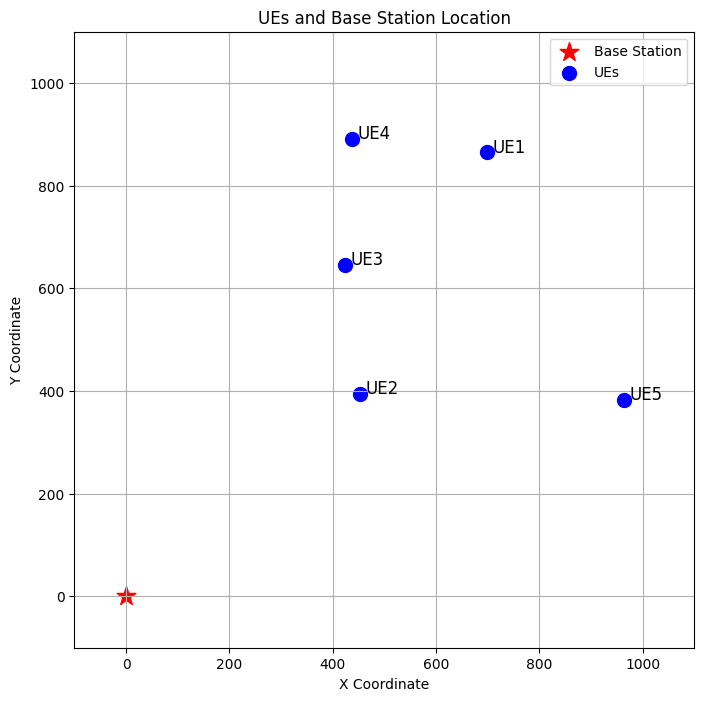

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
num_ues = 5
transmission_power_dbm = 46  # Transmission power in dBm
noise_power_dbm = -90  # Noise power in dBm
frequency_mhz = 2000  # Frequency in MHz
base_station_coords = (0, 0)
area_size = 1000
alpha = 0.5
num_rbs = 200
iterations = 150

# Generate random coordinates for UEs
np.random.seed(0)
ue_coords = np.random.uniform(0, area_size, (num_ues, 2))

# Function to update UE positions
def update_ue_positions(ue_coords, timeslot):
    step_size = 1.0
    ue_coords[0, 0] += step_size  # UE1 moving away
    ue_coords[0, 1] += step_size
    ue_coords[1, 0] -= step_size  # UE2 moving towards
    ue_coords[1, 1] -= step_size
    return ue_coords

# Cost Hata Model Parameters
def cost_hata_path_loss(d_km, frequency_mhz, base_height_m, ue_height_m, urban_area=True):
    A = 69.55 + 26.16 * np.log10(frequency_mhz) - 13.82 * np.log10(base_height_m)
    B = 44.9 - 6.55 * np.log10(base_height_m)
    C = (1.1 * np.log10(frequency_mhz) - 0.7) * ue_height_m - (1.56 * np.log10(frequency_mhz) - 0.8)
    if urban_area:
        path_loss = A + B * np.log10(d_km/1000) - C
    else:
        path_loss = A + B * np.log10(d_km/1000) - C
    return path_loss

# Convert transmission power and noise power to linear scale
transmission_power = 10 ** ((transmission_power_dbm - 30) / 10)  # in Watts
noise_power = 10 ** ((noise_power_dbm - 30) / 10)  # in Watts

#parameters
theta = np.zeros((num_ues, num_rbs))
neuron_states = np.random.choice([0, 1], size=(num_ues, num_rbs))
rb_bandwidth = 180e3  # 180 kHz
total_bandwidth = num_rbs * rb_bandwidth
avg_data_rates = np.ones(num_ues)  # Start with equal average data rates

# update average data rates
def update_avg_data_rates(allocation, channel_gains, transmission_power, noise_power, rb_bandwidth, avg_data_rates, decay=0.8):
    for u in range(num_ues):
        data_rate = 0
        for rb in allocation[u]:
            data_rate += rb_bandwidth * np.log2(1 + (transmission_power * channel_gains[u]) / (noise_power*total_bandwidth))
        avg_data_rates[u] = decay * avg_data_rates[u] + (1 - decay) * data_rate
    return avg_data_rates

# calculate weights
def calculate_weights(channel_gains, transmission_power, noise_power, rb_bandwidth, alpha, avg_data_rates):
    weights = np.zeros((num_ues, num_rbs, num_ues, num_rbs))
    for u in range(num_ues):
        for b in range(num_rbs):
            for u_prime in range(num_ues):
                for b_prime in range(num_rbs):
                    if u == u_prime and b == b_prime:
                        weights[u, b, u_prime, b_prime] = ((rb_bandwidth) * np.log2(
                            1 + (transmission_power * channel_gains[u]) / (noise_power*total_bandwidth)
                        ) )/ (avg_data_rates[u] ** alpha)
                    else:
                        weights[u, b, u_prime, b_prime] = 0
    return weights

def update_neurons(neuron_states, weights, theta):
    new_states = np.copy(neuron_states)
    num_ues, num_rbs = neuron_states.shape

    for b in range(num_rbs):
        max_value = -np.inf
        selected_ue = -1

        for u in range(num_ues):
            weighted_sum = np.sum(weights[u, b, :, :] * neuron_states)

            if weighted_sum >= theta[u, b] and weighted_sum > max_value:
                max_value = weighted_sum
                selected_ue = u

        new_states[:, b] = 0
        if selected_ue != -1:
            new_states[selected_ue, b] = 1

    return new_states

# allocation
def interpret_allocation(final_states):
    allocation = {}
    for u in range(num_ues):
        allocation[u] = np.where(final_states[u] == 1)[0]  # Find RBs allocated to this UE
    return allocation

# evaluate allocation (data rates)
def evaluate_allocation(allocation, channel_gains, transmission_power, noise_power, rb_bandwidth):
    total_data_rate = 0
    UE_data_rate = []
    for u in range(num_ues):
        data_rate = 0
        for rb in allocation[u]:
            data_rate += rb_bandwidth * np.log2(1 + (transmission_power * channel_gains[u]) / noise_power)
        UE_data_rate.append(data_rate)
        total_data_rate += data_rate
    return UE_data_rate, total_data_rate

# Jain's Fairness Index
def calculate_fairness(allocation, channel_gains, transmission_power, noise_power, rb_bandwidth):
    data_rates = []
    for u in range(num_ues):
        data_rate = 0
        for rb in allocation[u]:
            data_rate += rb_bandwidth * np.log2(1 + (transmission_power * channel_gains[u]) / noise_power)
        data_rates.append(data_rate)

    data_rates = np.array(data_rates)
    fairness_index = (np.sum(data_rates) ** 2) / (num_ues * np.sum(data_rates ** 2))
    return fairness_index

def compute_energy(neuron_states, weights):
    energy = 0
    num_ues, num_rbs = neuron_states.shape
    for b in range(num_rbs):
        for u in range(num_ues):
            weighted_sum = np.sum(weights[u, b, :, :] * neuron_states)
            energy -= weighted_sum  # Assuming energy function to be minimized
    return energy

# Run the network until convergence and track data
def run_hopfield(neuron_states, weights, theta, avg_data_rates, iterations):
    data_rate_history = []
    fairness_history = []
    energy_history = []

    for i in range(iterations):
        # Update UE positions for this iteration
        ue_coords_updated = update_ue_positions(ue_coords, i)

        # Recalculate distances and path losses
        distances = np.linalg.norm(ue_coords_updated - np.array(base_station_coords), axis=1)
        path_losses = np.array([cost_hata_path_loss(d / 1000, frequency_mhz, base_height_m=30, ue_height_m=1.5) for d in distances])
        snr_db = transmission_power_dbm - path_losses - noise_power_dbm
        snr_linear = 10 ** (snr_db / 10)
        channel_gains = np.sqrt(snr_linear)

        # Update weights based on new channel gains
        weights = calculate_weights(channel_gains, transmission_power, noise_power, rb_bandwidth, alpha, avg_data_rates)
        neuron_states = update_neurons(neuron_states, weights, theta)
        allocation = interpret_allocation(neuron_states)

        # Update average data rates
        avg_data_rates = update_avg_data_rates(allocation, channel_gains, transmission_power, noise_power, rb_bandwidth, avg_data_rates)

        UE_data_rate, _ = evaluate_allocation(allocation, channel_gains, transmission_power, noise_power, rb_bandwidth)
        data_rate_history.append(UE_data_rate)

        fairness = calculate_fairness(allocation, channel_gains, transmission_power, noise_power, rb_bandwidth)
        fairness_history.append(fairness)

        energy = compute_energy(neuron_states, weights)
        energy_history.append(energy)

        #print(f"Iteration {i+1}: Allocation: {allocation}")
        #print(f"UE Data Rates: {UE_data_rate}")
        #print(f"Fairness Index: {fairness}")
        #print(f"Energy: {energy}")

    return neuron_states, data_rate_history, fairness_history

# Calculate initial weights
distances = np.linalg.norm(ue_coords - np.array(base_station_coords), axis=1)
path_losses = np.array([cost_hata_path_loss(d / 1000, frequency_mhz, base_height_m=30, ue_height_m=1.5) for d in distances])
snr_db = transmission_power_dbm - path_losses - noise_power_dbm
snr_linear = 10 ** (snr_db / 10)
channel_gains = np.sqrt(snr_linear)

weights = calculate_weights(channel_gains, transmission_power, noise_power, rb_bandwidth, alpha, avg_data_rates)

# Run Hopfield
final_states, data_rate_history, fairness_history = run_hopfield(neuron_states, weights, theta, avg_data_rates, iterations)

# Final allocation and data rates
allocation = interpret_allocation(final_states)
UE_data_rate, total_data_rate = evaluate_allocation(allocation, channel_gains, transmission_power, noise_power, rb_bandwidth)
print("Final RB Allocation:", allocation)
print("Final UE Data Rates:", UE_data_rate)
print("Total Data Rate:", total_data_rate)

plt.figure(figsize=(8, 8))
plt.scatter(base_station_coords[0], base_station_coords[1], color='red', marker='*', s=200, label='Base Station')
plt.scatter(ue_coords[:, 0], ue_coords[:, 1], color='blue', marker='o', s=100, label='UEs')

for i, (x, y) in enumerate(ue_coords):
    plt.text(x + 10, y, f'UE{i+1}', fontsize=12)

plt.xlim(-100, 1100)
plt.ylim(-100, 1100)
plt.title('UEs and Base Station Location')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.legend()
plt.show()


##Approach 2: Use a DQN for resource allocation


* Agent: The base station acts as the agent that allocates RBs to the UEs.
* State: The state consists of the current conditions of the network, such as user channel gains, the RB allocation status, and the history of past allocations.
* Action: The action is to assign a set of RBs to different UEs.
* Reward: The reward is designed to reflect the performance of the network, including maximizing data rates and ensuring fairness across all UEs. The DQN learns to maximize cumulative rewards over time.
* Objective: To train the DQN agent to learn an optimal resource allocation policy that adapts to network dynamics and achieves both high throughput and fairness.


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

# Parameters
NUM_UES = 5
NUM_RBS = 200
TRANSMISSION_POWER_DBM = 46
NOISE_POWER_DBM = -90
FREQUENCY_MHZ = 2000
BASE_STATION_COORDS = (0, 0)
AREA_SIZE = 1000

# DQN Hyperparameters
BATCH_SIZE = 32
GAMMA = 0.99
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995
LEARNING_RATE = 0.001
MEMORY_SIZE = 10000
TARGET_UPDATE = 10

class Environment:
    def __init__(self):
        self.reset()

    def reset(self):
        np.random.seed(0)
        self.ue_coords = np.random.uniform(0, AREA_SIZE, (NUM_UES, 2))
        self.update_channel_gains()
        self.current_allocation = np.zeros((NUM_UES, NUM_RBS), dtype=int)
        return self._get_state()

    def update_channel_gains(self):
        distances = np.linalg.norm(self.ue_coords - np.array(BASE_STATION_COORDS), axis=1)
        path_losses = np.array([self.cost_hata_path_loss(d / 1000) for d in distances])
        snr_db = TRANSMISSION_POWER_DBM - path_losses - NOISE_POWER_DBM
        snr_linear = 10 ** (snr_db / 10)
        self.channel_gains = np.sqrt(snr_linear)

    def cost_hata_path_loss(self, d_km):
        A = 69.55 + 26.16 * np.log10(FREQUENCY_MHZ) - 13.82 * np.log10(30)
        B = 44.9 - 6.55 * np.log10(30)
        C = (1.1 * np.log10(FREQUENCY_MHZ) - 0.7) * 1.5 - (1.56 * np.log10(FREQUENCY_MHZ) - 0.8)
        return A + B * np.log10(d_km) - C

    def step(self, action):
        ue, rb = action // NUM_RBS, action % NUM_RBS
        self.current_allocation[ue, rb] = 1
        reward = self._calculate_reward()
        done = np.sum(self.current_allocation) == NUM_RBS
        self._update_ue_positions()
        return self._get_state(), reward, done

    def _get_state(self):
        return np.concatenate([self.current_allocation.flatten(), self.channel_gains])

    def _calculate_reward(self):
        data_rates = self._calculate_data_rates()
        return np.sum(data_rates) + self._calculate_fairness(data_rates)

    def _calculate_data_rates(self):
        rb_bandwidth = 180e3
        transmission_power = 10 ** ((TRANSMISSION_POWER_DBM - 30) / 10)
        noise_power = 10 ** ((NOISE_POWER_DBM - 30) / 10)
        data_rates = np.zeros(NUM_UES)
        for u in range(NUM_UES):
            allocated_rbs = np.sum(self.current_allocation[u])
            if allocated_rbs > 0:
                data_rates[u] = allocated_rbs * rb_bandwidth * np.log2(1 + (transmission_power * self.channel_gains[u]) / (noise_power * NUM_RBS * rb_bandwidth))
        return data_rates

    def _calculate_fairness(self, data_rates):
        return (np.sum(data_rates) ** 2) / (NUM_UES * np.sum(data_rates ** 2))

    def _update_ue_positions(self):
        step_size = 1.0
        self.ue_coords[0, 0] += step_size
        self.ue_coords[0, 1] += step_size
        self.ue_coords[1, 0] -= step_size
        self.ue_coords[1, 1] -= step_size
        self.update_channel_gains()

class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, state, action, next_state, reward):
        self.memory.append((state, action, next_state, reward))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

def select_action(state, policy_net, epsilon):
    if random.random() > epsilon:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(NUM_UES * NUM_RBS)]], dtype=torch.long)

def optimize_model(policy_net, target_net, optimizer, memory):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = list(zip(*transitions))

    state_batch = torch.cat(batch[0])
    action_batch = torch.cat(batch[1])
    reward_batch = torch.cat(batch[3])

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch[2])), dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch[2] if s is not None])

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def train_dqn(num_episodes):
    env = Environment()
    input_size = NUM_UES * NUM_RBS + NUM_UES
    output_size = NUM_UES * NUM_RBS

    policy_net = DQN(input_size, output_size)
    target_net = DQN(input_size, output_size)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
    memory = ReplayMemory(MEMORY_SIZE)

    epsilon = EPSILON_START

    for episode in range(num_episodes):
        state = env.reset()
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        total_reward = 0

        while True:
            action = select_action(state, policy_net, epsilon)
            next_state, reward, done = env.step(action.item())
            total_reward += reward

            next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
            reward = torch.tensor([reward], dtype=torch.float32)

            memory.push(state, action, next_state, reward)
            state = next_state

            optimize_model(policy_net, target_net, optimizer, memory)

            if done:
                break

        epsilon = max(EPSILON_END, EPSILON_DECAY * epsilon)

        if episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

        print(f"Episode {episode + 1}, Total Reward: {total_reward}")

    return policy_net

# Training
trained_model = train_dqn(num_episodes=500)
def perform_allocation(model, env):
    model.eval()
    state = env.reset()
    allocation = np.zeros((NUM_UES, NUM_RBS), dtype=int)

    with torch.no_grad():
        for _ in range(NUM_RBS):
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            action = model(state_tensor).max(1)[1].view(1, 1).item()

            ue, rb = action // NUM_RBS, action % NUM_RBS

            # Ensure we don't allocate the same RB twice
            while allocation[ue, rb] == 1:
                action = (action + 1) % (NUM_UES * NUM_RBS)
                ue, rb = action // NUM_RBS, action % NUM_RBS

            allocation[ue, rb] = 1
            state, _, _ = env.step(action)

    return allocation

env = Environment()
final_allocation = perform_allocation(trained_model, env)
print("Final Resource Block Allocation:")
for ue in range(NUM_UES):
    allocated_rbs = np.where(final_allocation[ue] == 1)[0]
    print(f"UE {ue + 1}: {allocated_rbs.tolist()}")

data_rates = env._calculate_data_rates()
for ue in range(NUM_UES):
    print(f"UE {ue + 1} Data Rate: {data_rates[ue]:.2f} bps")

# Calculate and print the fairness index
fairness = env._calculate_fairness(data_rates)
print(f"Fairness Index: {fairness:.4f}")

#total system throughput
total_throughput = np.sum(data_rates)
print(f"Total System Throughput: {total_throughput:.2f} bps")

Episode 1, Total Reward: 89607175223.16658
Episode 2, Total Reward: 87634515555.40341
Episode 3, Total Reward: 89249433610.1026
Episode 4, Total Reward: 87260139699.39465
Episode 5, Total Reward: 92910168733.84747
Episode 6, Total Reward: 89559787584.69928
Episode 7, Total Reward: 90648292256.54575
Episode 8, Total Reward: 92166268556.80447
Episode 9, Total Reward: 88093992648.89857
Episode 10, Total Reward: 87805042081.19167
Episode 11, Total Reward: 88210533786.06569
Episode 12, Total Reward: 95254892151.24638
Episode 13, Total Reward: 91149772034.0397
Episode 14, Total Reward: 93164846117.72018
Episode 15, Total Reward: 102192141128.84444
Episode 16, Total Reward: 94748779948.46265
Episode 17, Total Reward: 95872480282.67853
Episode 18, Total Reward: 90238878278.91487
Episode 19, Total Reward: 99676159724.0373
Episode 20, Total Reward: 90095085921.31122
Episode 21, Total Reward: 93266254578.56853
Episode 22, Total Reward: 99396573540.54373
Episode 23, Total Reward: 96072204116.68147

KeyboardInterrupt: 